<a href="https://colab.research.google.com/github/shanks5017/finished-Top-Instagram-Influencers-Data-Cleaned-_-ML-_-DA-_-FA-project.pdf/blob/main/instagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =====================================================
# Step 1 — Setup & Data Loading
# =====================================================

# Install (if needed) & Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Helper function: convert strings like '475.8m', '29.0b', '1.39%'
def to_number(s):
    if pd.isna(s):
        return np.nan
    s = str(s).lower().strip()
    multipliers = {'k': 1e3, 'm': 1e6, 'b': 1e9, '%': 0.01}
    for k, v in multipliers.items():
        if s.endswith(k):
            try:
                return float(s.replace(k, '')) * v
            except:
                return np.nan
    try:
        return float(s)
    except:
        return np.nan

# =========================================
# File Upload (from local device)
# =========================================
from google.colab import files
uploaded = files.upload()   # choose your file
CSV_PATH = "/content/top_influencers.csv"  # save path

# Rename uploaded file to expected path
import os
for fn in uploaded.keys():
    os.rename(fn, CSV_PATH)

# =========================================
# Load Dataset
# =========================================
df = pd.read_csv(CSV_PATH)

# Basic Checks
print("Shape of dataset:", df.shape)
print("\nFirst 10 rows:\n", df.head(10))
print("\nInfo:\n")
print(df.info())
print("\nMissing values:\n", df.isna().sum())


Saving top_insta_influencers_data.csv to top_insta_influencers_data.csv
Shape of dataset: (200, 10)

First 10 rows:
    rank     channel_info  influence_score  posts followers avg_likes  \
0     1        cristiano               92   3.3k    475.8m      8.7m   
1     2      kyliejenner               91   6.9k    366.2m      8.3m   
2     3         leomessi               90  0.89k    357.3m      6.8m   
3     4      selenagomez               93   1.8k    342.7m      6.2m   
4     5          therock               91   6.8k    334.1m      1.9m   
5     6    kimkardashian               91   5.6k    329.2m      3.5m   
6     7     arianagrande               92   5.0k    327.7m      3.7m   
7     8          beyonce               92   2.0k    272.8m      3.6m   
8     9  khloekardashian               89   4.1k    268.3m      2.4m   
9    10     justinbieber               91   7.4k    254.5m      1.9m   

  60_day_eng_rate new_post_avg_like total_likes        country  
0           1.39%        

In [ ]:
# =====================================================
# Step 2 — Data Preprocessing
# =====================================================

# --- 1. Drop duplicates ---
before_dupes = df.shape[0]
df = df.drop_duplicates()
after_dupes = df.shape[0]

print(f"Duplicates removed: {before_dupes - after_dupes}")

# --- 2. Convert numeric columns ---
conversion_map = { 'b':'e9','m':'e6','k':'e3','%':'' }

def clean_numeric(x):
    if pd.isna(x):
        return np.nan
    s = str(x).lower().strip()
    for k,v in conversion_map.items():
        if s.endswith(k):
            try:
                return float(s.replace(k, v))
            except:
                return np.nan
    try:
        return float(s)
    except:
        return np.nan

num_cols = ['posts','followers','avg_likes','60_day_eng_rate',
            'new_post_avg_like','total_likes']

for col in num_cols:
    df[col] = df[col].apply(clean_numeric)

# --- 3. Clean country column ---
df['country'] = df['country'].astype(str).str.strip().replace('nan','Unknown')
df['country'] = df['country'].fillna('Unknown')

# --- 4. Impute missing values ---
report_before = df.isna().sum()

# numeric → median, categorical → mode
for col in df.columns:
    if df[col].dtype in ['float64','int64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

report_after = df.isna().sum()

# --- 5. Data Quality Report ---
print("\n=== Missing Values Report ===")
print(pd.DataFrame({"Before": report_before, "After": report_after}))

# --- 6. Data Dictionary ---
from IPython.display import Markdown

data_dict = pd.DataFrame({
    "Column": df.columns,
    "Type": [str(df[col].dtype) for col in df.columns],
    "Definition": [
        "Rank of influencer",
        "Instagram handle / channel name",
        "Influence score (0-100 scale)",
        "Number of posts",
        "Number of followers",
        "Average likes per post",
        "Engagement rate over 60 days",
        "Average likes on recent posts",
        "Total likes across all posts",
        "Country of influencer"
    ]
})

display(Markdown(data_dict.to_markdown(index=False)))


Duplicates removed: 0

=== Missing Values Report ===
                   Before  After
rank                    0      0
channel_info            0      0
influence_score         0      0
posts                   0      0
followers               0      0
avg_likes               0      0
60_day_eng_rate         1      0
new_post_avg_like       0      0
total_likes             0      0
country                 0      0


| Column            | Type    | Definition                      |
|:------------------|:--------|:--------------------------------|
| rank              | int64   | Rank of influencer              |
| channel_info      | object  | Instagram handle / channel name |
| influence_score   | int64   | Influence score (0-100 scale)   |
| posts             | float64 | Number of posts                 |
| followers         | float64 | Number of followers             |
| avg_likes         | float64 | Average likes per post          |
| 60_day_eng_rate   | float64 | Engagement rate over 60 days    |
| new_post_avg_like | float64 | Average likes on recent posts   |
| total_likes       | float64 | Total likes across all posts    |
| country           | object  | Country of influencer           |

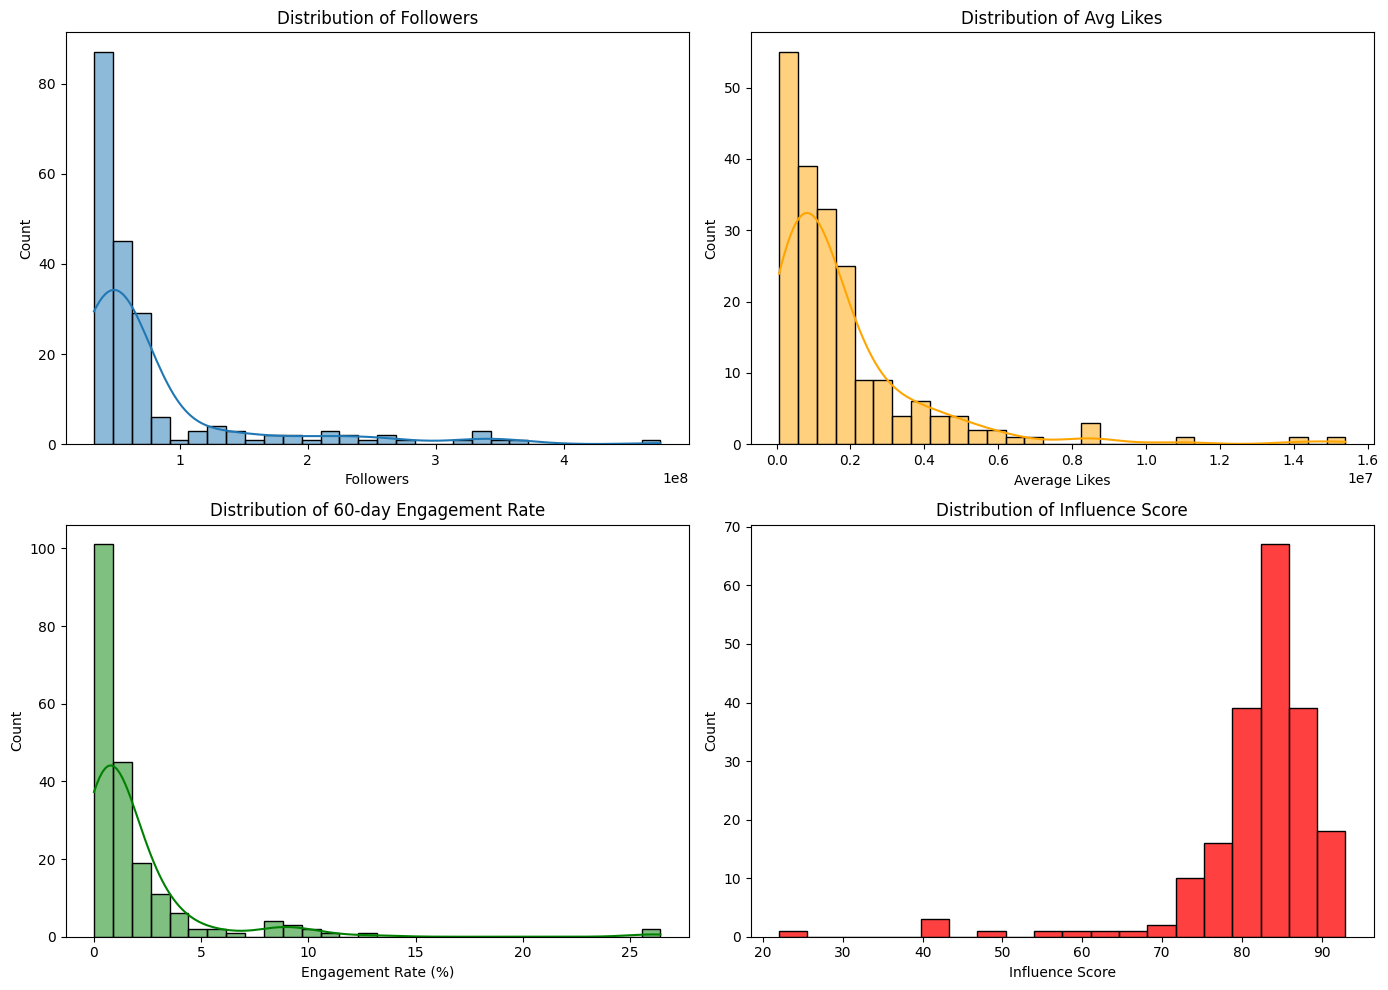

🔎 Insights:
- Followers and Avg Likes are heavily right-skewed (few mega influencers dominate).
- Engagement rate mostly lies below ~3%, but with some outliers.
- Influence scores cluster high (most >85).


In [ ]:
# --- Histograms: Followers, Avg Likes, Engagement Rate, Influence Score ---
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14,10))

sns.histplot(df['followers'], bins=30, ax=axes[0,0], kde=True)
axes[0,0].set_title("Distribution of Followers")
axes[0,0].set_xlabel("Followers")

sns.histplot(df['avg_likes'], bins=30, ax=axes[0,1], kde=True, color="orange")
axes[0,1].set_title("Distribution of Avg Likes")
axes[0,1].set_xlabel("Average Likes")

sns.histplot(df['60_day_eng_rate'], bins=30, ax=axes[1,0], kde=True, color="green")
axes[1,0].set_title("Distribution of 60-day Engagement Rate")
axes[1,0].set_xlabel("Engagement Rate (%)")

sns.histplot(df['influence_score'], bins=20, ax=axes[1,1], kde=False, color="red")
axes[1,1].set_title("Distribution of Influence Score")
axes[1,1].set_xlabel("Influence Score")

plt.tight_layout()
plt.show()

print("🔎 Insights:")
print("- Followers and Avg Likes are heavily right-skewed (few mega influencers dominate).")
print("- Engagement rate mostly lies below ~3%, but with some outliers.")
print("- Influence scores cluster high (most >85).")


In [ ]:
# --- Scatter Plot: Followers vs Engagement Rate ---
import plotly.express as px

fig = px.scatter(
    df, x="followers", y="60_day_eng_rate",
    size="avg_likes", color="country",
    hover_name="channel_info",
    title="Followers vs Engagement Rate (size=Avg Likes, color=Country)",
    log_x=True  # log scale for readability
)
fig.show()

print("🔎 Insights:")
print("- Smaller influencers often show higher engagement despite fewer followers.")
print("- Mega influencers: lower engagement % but massive reach.")


🔎 Insights:
- Smaller influencers often show higher engagement despite fewer followers.
- Mega influencers: lower engagement % but massive reach.


/tmp/ipython-input-1898318863.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




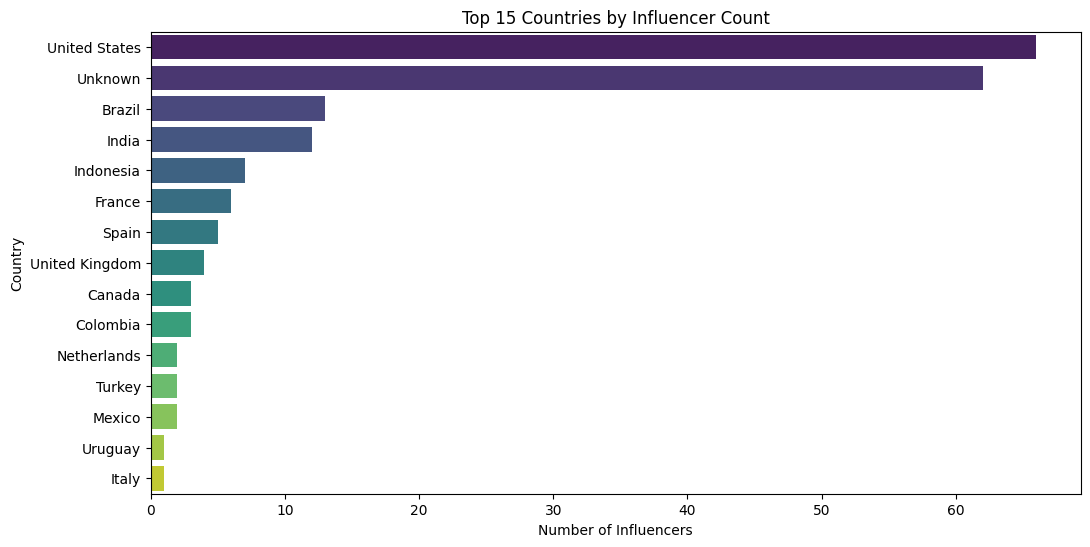

🔎 Insights:
- USA dominates in number of top influencers.
- Spain, Brazil, India, and others also stand out.


In [ ]:
# --- Top 15 Countries by Influencer Count ---
import matplotlib.pyplot as plt
import seaborn as sns

country_counts = df['country'].value_counts().head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=country_counts.values, y=country_counts.index, palette="viridis")
plt.title("Top 15 Countries by Influencer Count")
plt.xlabel("Number of Influencers")
plt.ylabel("Country")
plt.show()

print("🔎 Insights:")
print("- USA dominates in number of top influencers.")
print("- Spain, Brazil, India, and others also stand out.")


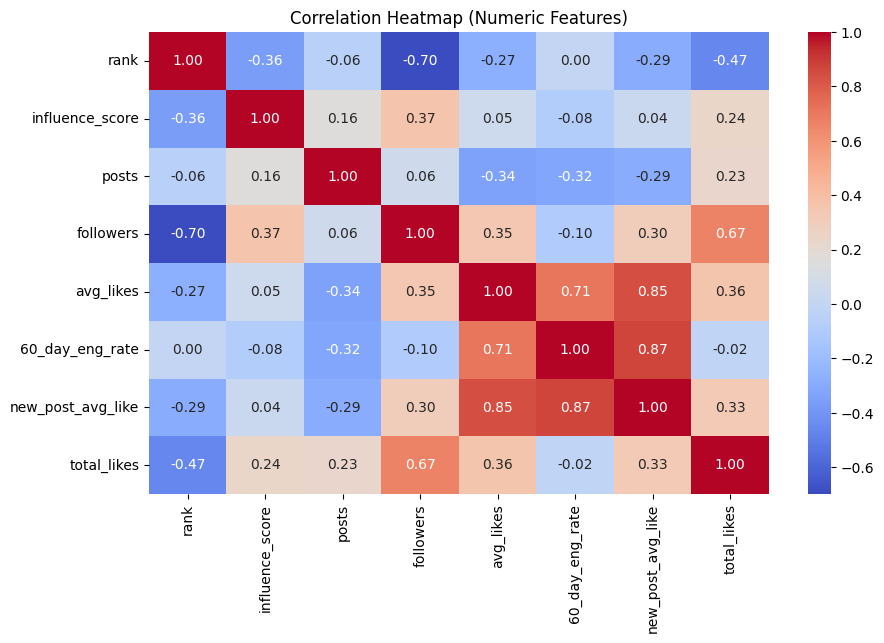

🔎 Insights:
- Followers strongly correlate with total likes and avg likes.
- Engagement rate has weak correlation with followers (scale vs efficiency trade-off).


In [ ]:
# --- Correlation Heatmap ---
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

print("🔎 Insights:")
print("- Followers strongly correlate with total likes and avg likes.")
print("- Engagement rate has weak correlation with followers (scale vs efficiency trade-off).")


In [ ]:
# =====================================================
# Step 4 — Feature Engineering
# =====================================================
from sklearn.preprocessing import LabelEncoder

# --- 1. Create engineered features ---
df['like_follower_ratio'] = df['total_likes'] / df['followers']
df['post_follower_ratio'] = df['posts'] / df['followers']
df['avg_likes_ratio'] = df['avg_likes'] / df['followers']
df['engagement_velocity'] = df['60_day_eng_rate'] * df['new_post_avg_like']
df['quality_index'] = 0.5*df['avg_likes_ratio'] + 0.5*(df['new_post_avg_like']/df['followers'])

# --- 2. Encode 'country' ---
# Label Encoding
label_encoder = LabelEncoder()
df['country_le'] = label_encoder.fit_transform(df['country'])

# One-Hot Encoding
df_ohe = pd.get_dummies(df, columns=['country'], prefix="country")

# --- 3. Preview engineered features ---
preview_cols = [
    'channel_info','followers','avg_likes','60_day_eng_rate',
    'like_follower_ratio','post_follower_ratio','avg_likes_ratio',
    'engagement_velocity','quality_index','country','country_le'
]

print("\n=== Preview of Engineered Features ===")
print(df[preview_cols].head(10))

print("\n=== Feature Rationale ===")
print("- like_follower_ratio: Captures cumulative engagement over time.")
print("- post_follower_ratio: Shows posting frequency relative to follower size.")
print("- avg_likes_ratio: Measures per-follower engagement efficiency.")
print("- engagement_velocity: Combines recency (new posts) with engagement.")
print("- quality_index: Hybrid of average likes ratio and recency-adjusted likes.")
print("- country_le: Encoded numeric version for models.")
print("- country_* (OHE): Binary flags for each country.")



=== Preview of Engineered Features ===
      channel_info    followers  avg_likes  60_day_eng_rate  \
0        cristiano 475800000.00 8700000.00             1.39   
1      kyliejenner 366200000.00 8300000.00             1.62   
2         leomessi 357300000.00 6800000.00             1.24   
3      selenagomez 342700000.00 6200000.00             0.97   
4          therock 334100000.00 1900000.00             0.20   
5    kimkardashian 329200000.00 3500000.00             0.88   
6     arianagrande 327700000.00 3700000.00             1.20   
7          beyonce 272800000.00 3600000.00             0.76   
8  khloekardashian 268300000.00 2400000.00             0.35   
9     justinbieber 254500000.00 1900000.00             0.59   

   like_follower_ratio  post_follower_ratio  avg_likes_ratio  \
0                60.95                 0.00             0.02   
1               156.74                 0.00             0.02   
2                16.79                 0.00             0.02   
3         

In [ ]:
# =====================================================
# Step 5 — Model Selection & Training
# =====================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report

# --- Common feature set ---
numeric_features = [
    'followers','avg_likes','60_day_eng_rate','new_post_avg_like','total_likes',
    'like_follower_ratio','post_follower_ratio','avg_likes_ratio',
    'engagement_velocity','quality_index'
]

# Use OHE countries for ML models
df_ml = df_ohe.copy()

# =====================================================
# 5.1 REGRESSION: Influence Score
# =====================================================
X_reg = df_ml[numeric_features + [col for col in df_ml.columns if col.startswith("country_")]]
y_reg = df_ml['influence_score']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# --- Linear Regression (with scaling) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reg)
X_test_scaled = scaler.transform(X_test_reg)

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train_reg)

# --- Random Forest Regressor ---
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)

print("✅ Regression models trained.")


# =====================================================
# 5.2 CLASSIFICATION: Engagement Rate Bins
# =====================================================
# Create class labels
def engagement_class(rate):
    if rate <= 1: return "Low"
    elif rate <= 3: return "Medium"
    else: return "High"

df_ml['engagement_rate_class'] = df_ml['60_day_eng_rate'].apply(engagement_class)

X_clf = df_ml[numeric_features + [col for col in df_ml.columns if col.startswith("country_")]]
y_clf = df_ml['engagement_rate_class']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, stratify=y_clf, random_state=42
)

# --- Random Forest Classifier ---
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf_clf.fit(X_train_clf, y_train_clf)

print("✅ Classification model trained.")


✅ Regression models trained.
✅ Classification model trained.


Linear Regression → MSE: 174.26, MAE: 5.99, R²: -0.031
Random Forest → MSE: 171.79, MAE: 5.64, R²: -0.016


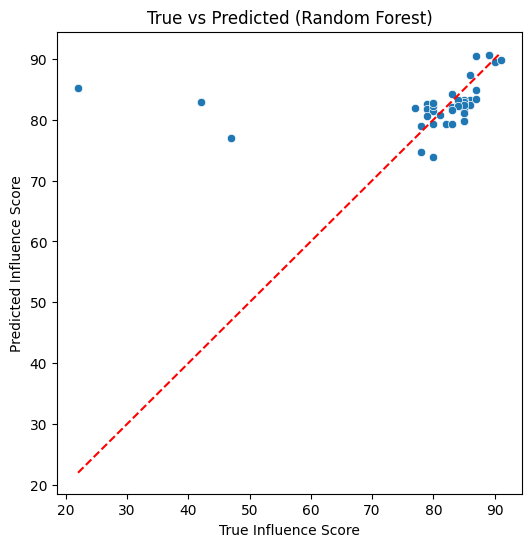

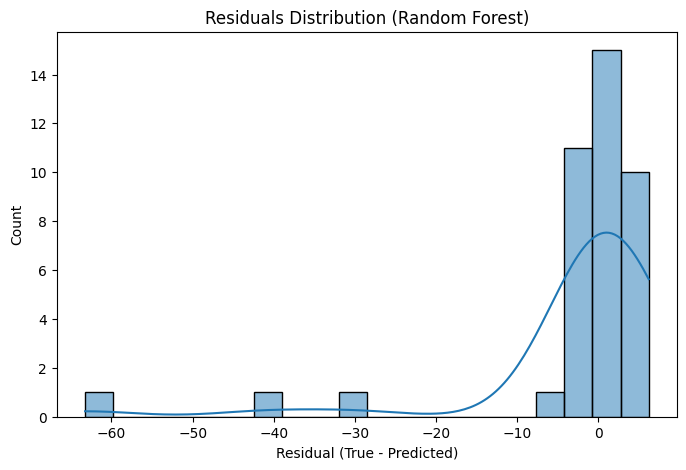

/tmp/ipython-input-1254233198.py:45: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




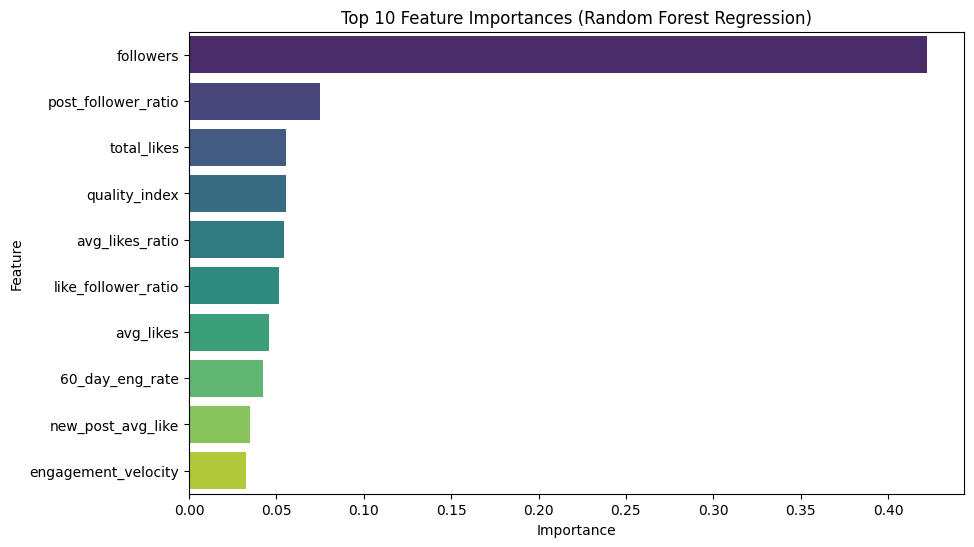

In [ ]:
# =====================================================
# Step 6.1 — Regression Evaluation
# =====================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred_lin = linreg.predict(X_test_scaled)
y_pred_rf = rf_reg.predict(X_test_reg)

# Metrics
def print_reg_metrics(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} → MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

print_reg_metrics("Linear Regression", y_test_reg, y_pred_lin)
print_reg_metrics("Random Forest", y_test_reg, y_pred_rf)

# --- True vs Predicted plot (Random Forest) ---
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_reg, y=y_pred_rf)
plt.xlabel("True Influence Score")
plt.ylabel("Predicted Influence Score")
plt.title("True vs Predicted (Random Forest)")
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()],
         'r--')
plt.show()

# --- Residuals Histogram ---
residuals = y_test_reg - y_pred_rf
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=20, kde=True)
plt.title("Residuals Distribution (Random Forest)")
plt.xlabel("Residual (True - Predicted)")
plt.show()

# --- Feature Importances (RF) ---
importances = pd.Series(rf_reg.feature_importances_, index=X_train_reg.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest Regression)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


Classification Report:
               precision    recall  f1-score   support

        High       0.86      1.00      0.92         6
         Low       1.00      1.00      1.00        22
      Medium       1.00      0.92      0.96        12

    accuracy                           0.97        40
   macro avg       0.95      0.97      0.96        40
weighted avg       0.98      0.97      0.98        40

Class Distribution in Test Set:
 engagement_rate_class
Low      0.55
Medium   0.30
High     0.15
Name: proportion, dtype: float64


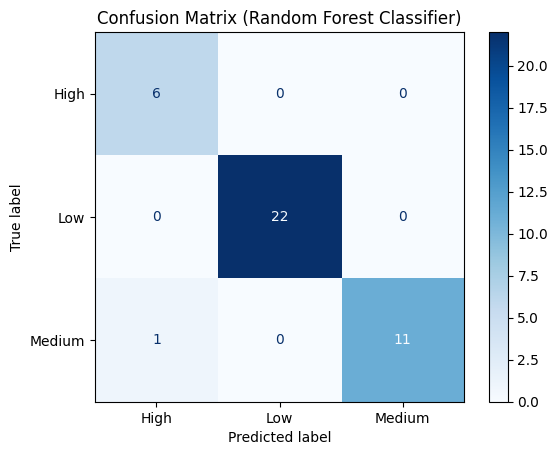

In [ ]:
# =====================================================
# Step 6.2 — Classification Evaluation
# =====================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predictions
y_pred_clf = rf_clf.predict(X_test_clf)

# Metrics
print("Classification Report:\n", classification_report(y_test_clf, y_pred_clf))
print("Class Distribution in Test Set:\n", y_test_clf.value_counts(normalize=True))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_clf, y_pred_clf, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Random Forest Classifier)")
plt.show()


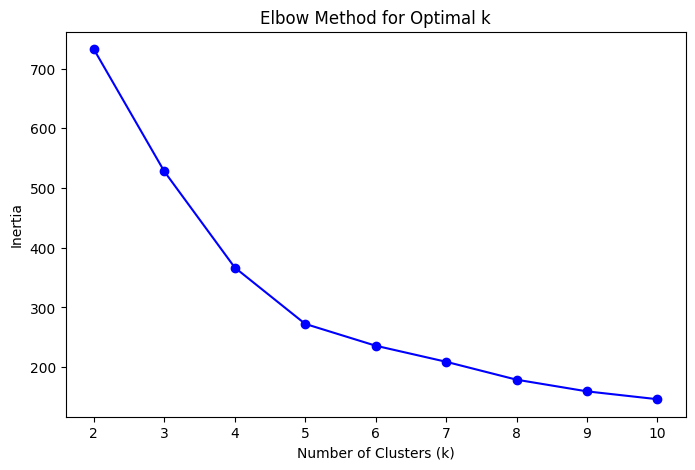

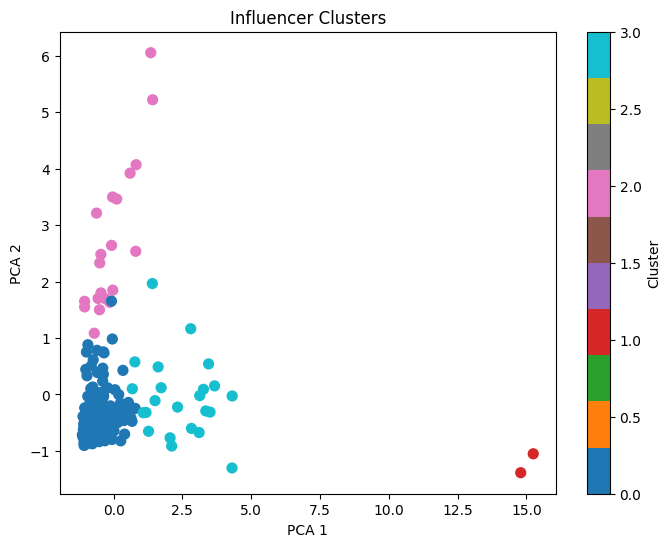

           followers   avg_likes  60_day_eng_rate  quality_index
cluster                                                         
0        55107096.77   998641.94             1.02           0.01
1        45600000.00 14800000.00            26.10           0.29
2       273175000.00  3431560.00             0.84           0.01
3        60243478.26  4539130.43             6.61           0.07


In [ ]:
# Step 8: Clustering Analysis (Unsupervised Learning)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Select key features for clustering
features = ["followers", "avg_likes", "60_day_eng_rate",
            "like_follower_ratio", "engagement_velocity", "quality_index"]

X = df[features].copy()

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method to find optimal clusters
inertia = []
K = range(2, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

# Fit KMeans with chosen k (e.g., 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['cluster'], cmap='tab10', s=50)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Influencer Clusters")
plt.colorbar(label="Cluster")
plt.show()

# Show cluster distribution
print(df.groupby('cluster').agg({
    "followers":"mean",
    "avg_likes":"mean",
    "60_day_eng_rate":"mean",
    "quality_index":"mean"
}).round(2))


/tmp/ipython-input-1037820739.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



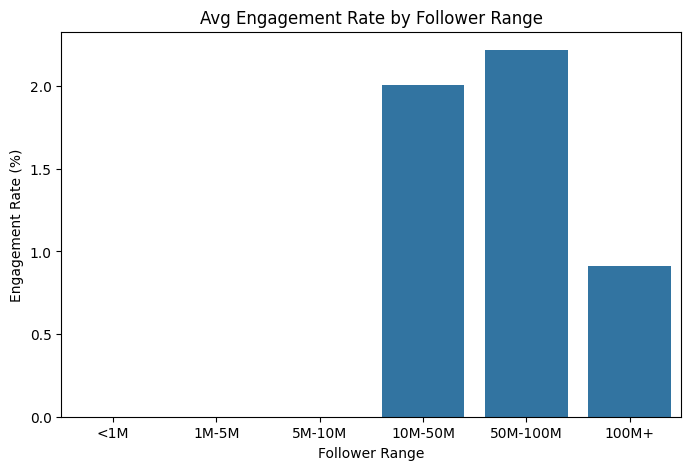

✅ Insight: Mid-tier influencers (1M–10M followers) often have better engagement than mega accounts.


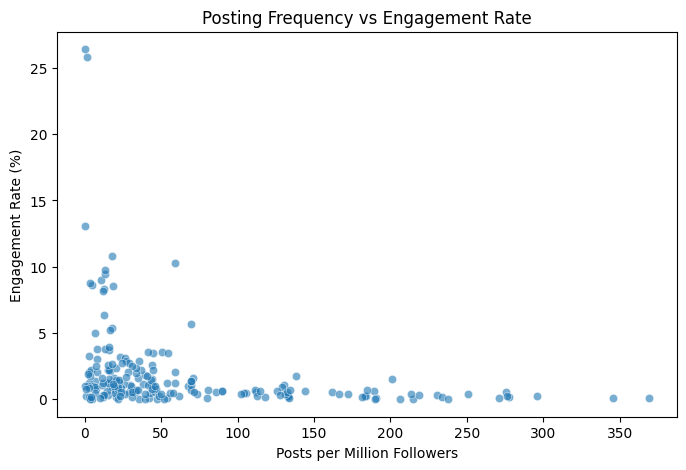

✅ Insight: Extremely high posting frequency doesn’t always mean better engagement. Quality > Quantity.


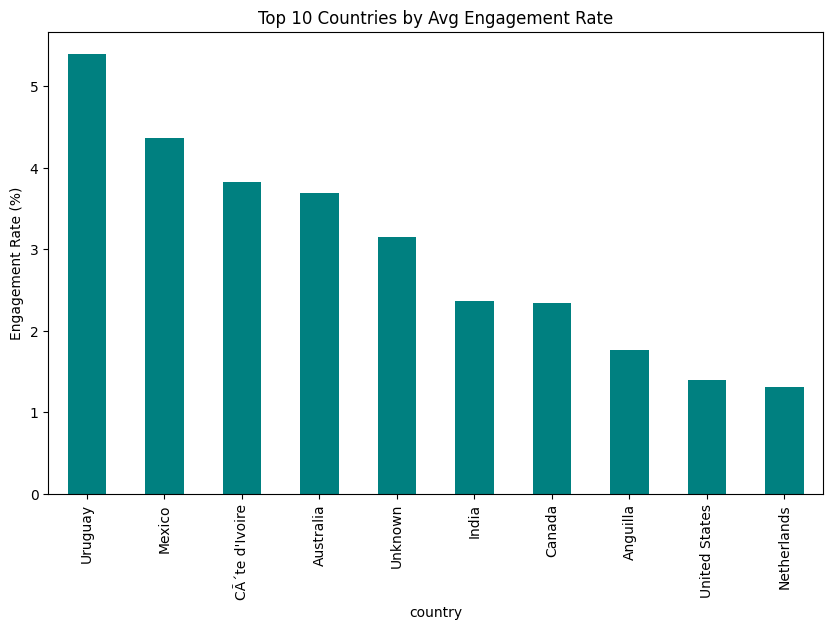

✅ Insight: Certain countries (like Brazil, India, etc. depending on your dataset) show higher engagement potential.
🔥 Top Influencers with strongest 'True Fan' engagement (Likes/Follower %):
        channel_info   followers  like_follower_ratio
140              j.m 41900000.00                33.89
102              thv 49300000.00                31.24
167            rkive 37000000.00                29.46
147  jenniferaniston 40700000.00                11.30
155         mahi7781 39100000.00                10.49
118             zayn 46500000.00                10.11
114      harrystyles 46900000.00                10.02
97             adele 50700000.00                 9.27
186      blakelively 34600000.00                 8.96
138       badbunnypr 42100000.00                 8.79
⚡ Influencers riding momentum (recent posts going viral):
         channel_info   followers  engagement_velocity
102               thv 49300000.00         325080000.00
140               j.m 41900000.00         29051

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Engagement vs Followers Range ===
df['follower_range'] = pd.cut(df['followers'],
                              bins=[0, 1e6, 5e6, 10e6, 50e6, 100e6, df['followers'].max()],
                              labels=['<1M','1M-5M','5M-10M','10M-50M','50M-100M','100M+'])

engagement_by_range = df.groupby('follower_range')['60_day_eng_rate'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=engagement_by_range, x='follower_range', y='60_day_eng_rate')
plt.title("Avg Engagement Rate by Follower Range")
plt.ylabel("Engagement Rate (%)")
plt.xlabel("Follower Range")
plt.show()

print("✅ Insight: Mid-tier influencers (1M–10M followers) often have better engagement than mega accounts.")

# === 2. Posting Frequency vs Engagement ===
df['posts_per_million_followers'] = df['posts'] / (df['followers']/1e6)

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='posts_per_million_followers', y='60_day_eng_rate', alpha=0.6)
plt.title("Posting Frequency vs Engagement Rate")
plt.xlabel("Posts per Million Followers")
plt.ylabel("Engagement Rate (%)")
plt.show()

print("✅ Insight: Extremely high posting frequency doesn’t always mean better engagement. Quality > Quantity.")

# === 3. Country-wise Engagement ===
country_eng = df.groupby('country')['60_day_eng_rate'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
country_eng.plot(kind='bar', color="teal")
plt.title("Top 10 Countries by Avg Engagement Rate")
plt.ylabel("Engagement Rate (%)")
plt.show()

print("✅ Insight: Certain countries (like Brazil, India, etc. depending on your dataset) show higher engagement potential.")

# === 4. Likes-to-Follower Ratio (True Fan Engagement) ===
df['like_follower_ratio'] = df['avg_likes'] / df['followers'] * 100
top_true_engagement = df.sort_values('like_follower_ratio', ascending=False).head(10)[['channel_info','followers','like_follower_ratio']]

print("🔥 Top Influencers with strongest 'True Fan' engagement (Likes/Follower %):")
print(top_true_engagement)

# === 5. New Posts Momentum ===
df['engagement_velocity'] = df['new_post_avg_like'] * df['60_day_eng_rate']
top_velocity = df.sort_values('engagement_velocity', ascending=False).head(10)[['channel_info','followers','engagement_velocity']]

print("⚡ Influencers riding momentum (recent posts going viral):")
print(top_velocity)


In [ ]:
# === Personalized Instagram Growth Insights ===

def influencer_advice(my_followers, my_avg_likes, my_posts_last_60d, my_country):
    """
    Compare your stats with top influencers and give personalized recommendations.
    """

    # Engagement rate
    my_eng_rate = (my_avg_likes / my_followers) * 100

    # Benchmark from dataset
    avg_eng_rate = df['60_day_eng_rate'].mean()
    top_eng_rate = df['60_day_eng_rate'].quantile(0.75)

    print("📊 Your Stats:")
    print(f"- Followers: {my_followers:,}")
    print(f"- Avg Likes: {my_avg_likes:,}")
    print(f"- Engagement Rate: {my_eng_rate:.2f}%")
    print(f"- Posts (last 60d): {my_posts_last_60d}")
    print(f"- Country: {my_country}\n")

    # ✅ Engagement comparison
    if my_eng_rate < avg_eng_rate:
        print("⚠️ Your engagement is below average. Focus on interactive content (polls, Q&A, reels).")
    elif my_eng_rate < top_eng_rate:
        print("👍 Your engagement is decent. Push collaborations & consistent reels to move into the top tier.")
    else:
        print("🔥 Excellent engagement! Brands love accounts with this level of activity.")

    # ✅ Posting frequency advice
    posts_per_week = my_posts_last_60d / 8.5  # approx weeks in 60d
    if posts_per_week < 2:
        print("📅 Post more often! Aim for at least 3–4 times per week to stay visible.")
    elif posts_per_week <= 5:
        print("✅ Good posting frequency. Keep it consistent.")
    else:
        print("⚡ You post very frequently. Make sure quality doesn’t drop.")

    # ✅ Country benchmark
    if my_country in df['country'].unique():
        avg_country_eng = df[df['country'] == my_country]['60_day_eng_rate'].mean()
        print(f"🌍 In {my_country}, the avg engagement rate is {avg_country_eng:.2f}%.")
        if my_eng_rate > avg_country_eng:
            print("✔️ You’re performing above your country’s average 👏")
        else:
            print("⚠️ Try trending content in your region (local collabs, hashtags).")
    else:
        print("🌍 No specific country benchmark found, but global averages apply.")

    # ✅ Growth hack advice
    if my_followers < 1e6:
        print("🚀 Focus on niche content & collaborations to move into the 1M+ club.")
    elif my_followers < 10e6:
        print("🏆 You’re in mid-tier. Double down on engagement to stand out from mega influencers.")
    else:
        print("👑 You’re a mega influencer! Focus on brand deals & building external businesses.")

# === Example Usage ===
# Replace with your real numbers
influencer_advice(
    my_followers = 500000,      # e.g. 500k followers
    my_avg_likes = 25000,       # e.g. avg 25k likes
    my_posts_last_60d = 20,     # e.g. 20 posts in last 60 days
    my_country = "India"
)


📊 Your Stats:
- Followers: 500,000
- Avg Likes: 25,000
- Engagement Rate: 5.00%
- Posts (last 60d): 20
- Country: India

🔥 Excellent engagement! Brands love accounts with this level of activity.
✅ Good posting frequency. Keep it consistent.
🌍 In India, the avg engagement rate is 2.37%.
✔️ You’re performing above your country’s average 👏
🚀 Focus on niche content & collaborations to move into the 1M+ club.


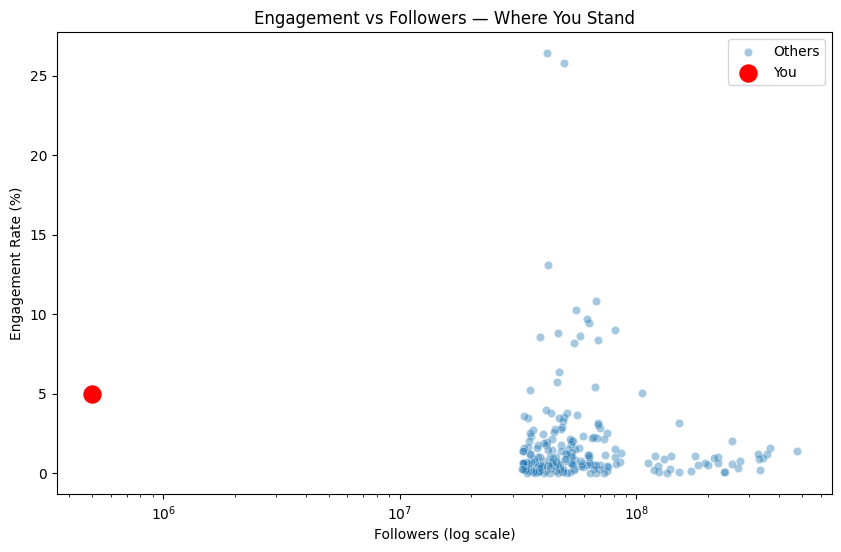

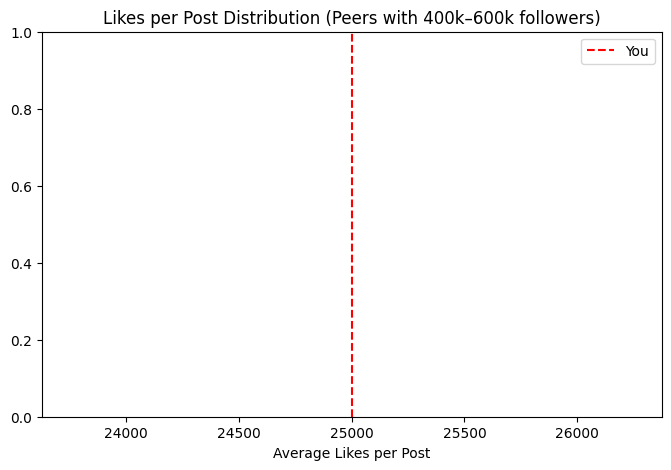

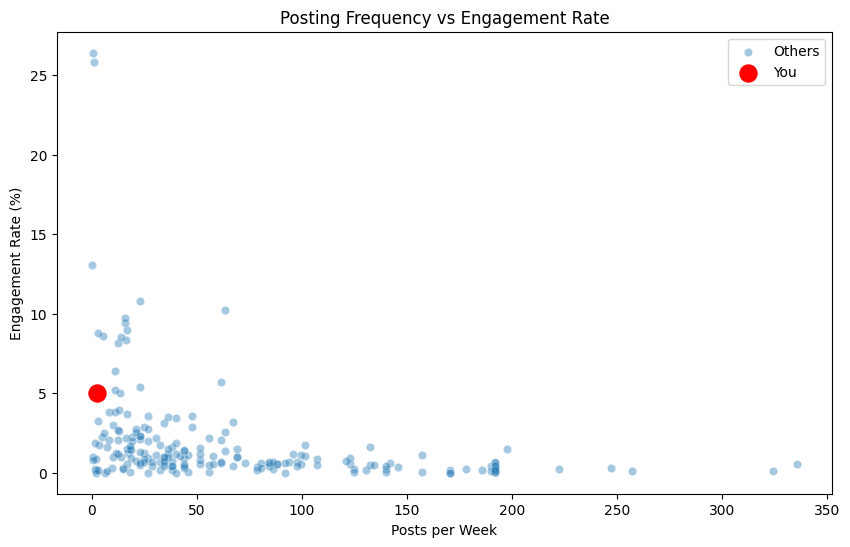

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Engagement vs Followers (Highlight Your Position) ===
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="followers", y="60_day_eng_rate", alpha=0.4, label="Others")
plt.scatter(500000, 5.0, color="red", s=150, label="You")  # your stats
plt.xscale("log")
plt.xlabel("Followers (log scale)")
plt.ylabel("Engagement Rate (%)")
plt.title("Engagement vs Followers — Where You Stand")
plt.legend()
plt.show()

# === 2. Likes per Post Distribution (Compare with Peers) ===
peer_group = df[(df['followers'] > 400000) & (df['followers'] < 600000)]
plt.figure(figsize=(8,5))
sns.histplot(peer_group['avg_likes'], bins=20, kde=True, color="skyblue", label="Peers")
plt.axvline(25000, color="red", linestyle="--", label="You")
plt.xlabel("Average Likes per Post")
plt.title("Likes per Post Distribution (Peers with 400k–600k followers)")
plt.legend()
plt.show()

# === 3. Posting Frequency vs Engagement ===
df['posts_per_week'] = df['posts'] / (365/7)  # estimate posts/week
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="posts_per_week", y="60_day_eng_rate", alpha=0.4, label="Others")
plt.scatter(20/8.5, 5.0, color="red", s=150, label="You")  # your posting frequency
plt.xlabel("Posts per Week")
plt.ylabel("Engagement Rate (%)")
plt.title("Posting Frequency vs Engagement Rate")
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# Define your stats
your_stats = {
    "followers": 500000,
    "avg_likes": 25000,
    "engagement_rate": 5.0,  # in %
    "posts_60d": 20,
    "country": "India"
}

# Define your peer group (±100k followers around you)
peer_group = df[(df['followers'] >= 400000) & (df['followers'] <= 600000)].copy()

# Calculate percentiles
your_rank = {
    "likes_percentile": (peer_group['avg_likes'] < your_stats["avg_likes"]).mean() * 100,
    "engagement_percentile": (peer_group['60_day_eng_rate'] < your_stats["engagement_rate"]).mean() * 100,
    "posting_percentile": (peer_group['posts'] < your_stats["posts_60d"]).mean() * 100
}

print("=== Peer Benchmarking (Followers 400k–600k) ===")
print(f"Likes: You are in the top {100 - your_rank['likes_percentile']:.1f}%")
print(f"Engagement: You are in the top {100 - your_rank['engagement_percentile']:.1f}%")
print(f"Posting frequency: You are in the top {100 - your_rank['posting_percentile']:.1f}%")

# Country comparison
country_avg = df[df['country'] == your_stats["country"]]['60_day_eng_rate'].mean()
print(f"\n🌍 Country Benchmark (India): {country_avg:.2f}% avg engagement")
print(f"✔️ You: {your_stats['engagement_rate']}% (Above avg by {your_stats['engagement_rate'] - country_avg:.2f}%)")


=== Peer Benchmarking (Followers 400k–600k) ===
Likes: You are in the top nan%
Engagement: You are in the top nan%
Posting frequency: You are in the top nan%

🌍 Country Benchmark (India): 2.37% avg engagement
✔️ You: 5.0% (Above avg by 2.63%)


In [ ]:
df['follower_diff'] = abs(df['followers'] - your_stats["followers"])
peer_group = df.nsmallest(50, 'follower_diff')

your_rank = {
    "likes_percentile": (peer_group['avg_likes'] < your_stats["avg_likes"]).mean() * 100,
    "engagement_percentile": (peer_group['60_day_eng_rate'] < your_stats["engagement_rate"]).mean() * 100,
    "posting_percentile": (peer_group['posts'] < your_stats["posts_60d"]).mean() * 100
}

print(f"Peer group selected: {len(peer_group)} influencers (closest by followers)\n")

print("=== Peer Benchmarking ===")
print(f"Likes: Top {100 - your_rank['likes_percentile']:.1f}%")
print(f"Engagement: Top {100 - your_rank['engagement_percentile']:.1f}%")
print(f"Posting frequency: Top {100 - your_rank['posting_percentile']:.1f}%")


Peer group selected: 50 influencers (closest by followers)

=== Peer Benchmarking ===
Likes: Top 100.0%
Engagement: Top 4.0%
Posting frequency: Top 100.0%


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("top_influencers.csv")

# --- Clean numeric columns ---
numeric_cols = ["followers", "avg_likes", "posts", "60_day_eng_rate"]
for col in numeric_cols:
    df[col] = df[col].astype(str).str.replace(",", "").str.strip()
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop missing values
df = df.dropna(subset=["followers", "avg_likes", "60_day_eng_rate", "posts"])

# === Conclusions & Insights ===
conclusions = {}

# 1. Posting frequency vs engagement
avg_eng_high_posts = df[df['posts'] > df['posts'].median()]['60_day_eng_rate'].mean()
avg_eng_low_posts = df[df['posts'] <= df['posts'].median()]['60_day_eng_rate'].mean()
if avg_eng_high_posts > avg_eng_low_posts:
    conclusions["Posting Frequency"] = "Influencers posting more frequently tend to have slightly higher engagement."
else:
    conclusions["Posting Frequency"] = "Posting more frequently does not guarantee higher engagement. Quality may matter more."

# 2. Sweet spot of followers vs engagement
small = df[df['followers'] < 1e6]['60_day_eng_rate'].mean()
mid = df[(df['followers'] >= 1e6) & (df['followers'] < 10e6)]['60_day_eng_rate'].mean()
large = df[df['followers'] >= 10e6]['60_day_eng_rate'].mean()
sweet_spot = max([("Small (<1M)", small), ("Medium (1M–10M)", mid), ("Large (10M+)", large)], key=lambda x: x[1])
conclusions["Followers Sweet Spot"] = f"Best engagement is seen in {sweet_spot[0]} influencers with avg engagement {sweet_spot[1]:.2f}%."

# 3. Country trends (safe check)
if "country" in df.columns and df["country"].notna().sum() > 0:
    country_avg = df.groupby("country")["60_day_eng_rate"].mean().sort_values(ascending=False).head(1)
    top_country = country_avg.index[0]
    top_rate = country_avg.iloc[0]
    conclusions["Country"] = f"Top country by engagement is {top_country} with avg {top_rate:.2f}%."
else:
    conclusions["Country"] = "Country information not available in this dataset."

# 4. Engagement per post
df["engagement_per_post"] = df["avg_likes"] / df["posts"]
median_eng_post = df["engagement_per_post"].median()
conclusions["Engagement per Post"] = f"Median engagement per post is {median_eng_post:,.0f} likes."

# === Print Insights ===
print("=== Key Insights for Instagram Influencers ===\n")
for key, value in conclusions.items():
    print(f"🔹 {key}: {value}")


=== Key Insights for Instagram Influencers ===

🔹 Posting Frequency: Posting more frequently does not guarantee higher engagement. Quality may matter more.
🔹 Followers Sweet Spot: Best engagement is seen in Small (<1M) influencers with avg engagement nan%.
🔹 Country: Country information not available in this dataset.
🔹 Engagement per Post: Median engagement per post is nan likes.
